## This code uses the adaptive metropolis algorithm to sample from the posterior distribution using a nonlinear sine function as the simulator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, invgamma, uniform



In [3]:

def adaptive_metropolis_s2update(f, data, prior_F, theta0, k0, M, covar, UB, LB):
    n_par = len(theta0)
    chain = np.zeros((n_par, M))
    s2chain = np.zeros(M)
    n_y = len(data)

    if covar is None or len(covar) == 0:
        covar = np.eye(n_par) * 0.1 * np.abs(theta0)

    def ss_func(param, data):
        return np.sum((f(param) - data) ** 2)
    
    def lik_func(ss, s2):
        return np.exp(-ss / (2 * s2)) * (2 * np.pi * s2) ** (-n_y / 2)
    
    chain[:, 0] = theta0
    ss_old = ss_func(theta0, data)
    sig_s = ss_old / (n_y - n_par)  # Estimate of error variance
    lik_old = lik_func(ss_old, sig_s)
    prior_old = prior_F(theta0)
    R = np.linalg.cholesky(covar)

    # Error variance hyperparameters
    n_s = 0.01  # For inverse gamma
    aval = 0.5 * (n_s + n_y)  # This is constant
    bval = 0.5 * (n_s * sig_s + ss_old)
    s2chain[0] = 1. / invgamma.rvs(aval, scale=bval)

    # Initialize covariance estimates
    Vk = covar
    theta_bar = theta0
    Ip = np.eye(n_par) * 1e-12  # Small jitter on diagonal for stability
    sp_cov = (2.38 ** 2) / n_par

    num_acc = 0
    prob_acc = uniform.rvs(size=M)

    for i in range(1, M):
        theta_star = chain[:, i - 1] + R.T @ np.random.normal(0, 1, n_par)

        if np.any(theta_star > UB) or np.any(theta_star < LB):
            ss_star = -np.inf
            lik_star = -np.inf
        else:
            ss_star = ss_func(theta_star, data)
            lik_star = lik_func(ss_star, s2chain[i - 1])
            lik_old = lik_func(ss_old, s2chain[i - 1])  # Recompute for the same s2 value
        
        prior_star = prior_F(theta_star)

        acc_prob = (prior_star * lik_star) / (prior_old * lik_old)
        if acc_prob > prob_acc[i]:
            chain[:, i] = theta_star
            ss_old = ss_star
            lik_old = lik_star
            prior_old = prior_star
            num_acc += 1
        else:
            chain[:, i] = chain[:, i - 1]
        
        # Update sigma squared using an inverse gamma
        bval = 0.5 * (n_s * sig_s + ss_old)
        s2chain[i] = 1. / invgamma.rvs(aval, scale=bval)

        # Update covariance and mean parameter
        theta_bar_old = theta_bar
        theta_bar = (i / (i + 1)) * theta_bar_old + chain[:, i] / (i + 1)
        Vk = ((i - 1) * Vk / i + (sp_cov / i) * (i * np.outer(theta_bar_old, theta_bar_old) -
             (i + 1) * np.outer(theta_bar, theta_bar) + np.outer(chain[:, i], chain[:, i]) + Ip))
        
        if i % k0 == 0:  # Update covariance in sampling
            R = np.linalg.cholesky(Vk)

    print('Acceptance rate:')
    print((num_acc / M) * 100)

    return chain, s2chain

In [21]:
# Define the Sine model
def sin_model(q, x):
    return q[0] + q[1] * np.sin(np.pi * q[2] * x)

# Parameters
xspace = np.linspace(-5, 5, 20)
param_star = np.array([5, 1, 0.3])
num_param = 3
n_xpts = len(xspace)
f_mod = lambda param: sin_model(param, xspace)
true_signal = f_mod(param_star)

# Adapt every 1000 samples for Adaptive Metropolis
k0 = 1000

# Measurement noise
noise_var = 0.1  # Example value
M = 10000  # Number of MCMC iterations
theta0 = np.array(param_star) * 0.8  # Initial parameter guess

# Generate data with noise
data = true_signal + np.random.normal(0, np.sqrt(noise_var), n_xpts)

# Sensitivity analysis for estimated covariance
S = np.zeros((n_xpts, num_param))
h = 1e-6
f_theta0 = f_mod(theta0)
for i in range(num_param):
    param_step = theta0.copy()
    param_step[i] += h
    S[:, i] = (f_mod(param_step) - f_theta0) / h

F = S.T @ S
s2_est = np.sum((data - f_mod(theta0)) ** 2) / (n_xpts - num_param)
covar_est = s2_est * np.linalg.inv(F)

# Define the prior
UB_uni = np.array([10, 4, 1])  # Upper bounds
LB_uni = np.array([1, 0.1, 0.01])  # Lower bounds




In [22]:
# Define prior
def prior_unif(param, a, b):
    return 1 / np.prod(b - a)





In [23]:
# Uniform prior
prior_F = lambda param: prior_unif(param, LB_uni, UB_uni)
theta0 = param_star
M = 10000
# Chain when covariance is not from sensitivity
# To do this, just set k0 to be large (so it never updates)
chain_Met, s2_Met = adaptive_metropolis_s2update(f_mod, data, prior_F, theta0, 1e8, M, covar_est, UB_uni, LB_uni)


Acceptance rate:
47.12


In [24]:
# Chain when covariance is updated
chain_AM, s2_AM = adaptive_metropolis_s2update(f_mod, data, prior_F, theta0, k0, M, covar_est, UB_uni, LB_uni)


Acceptance rate:
26.150000000000002


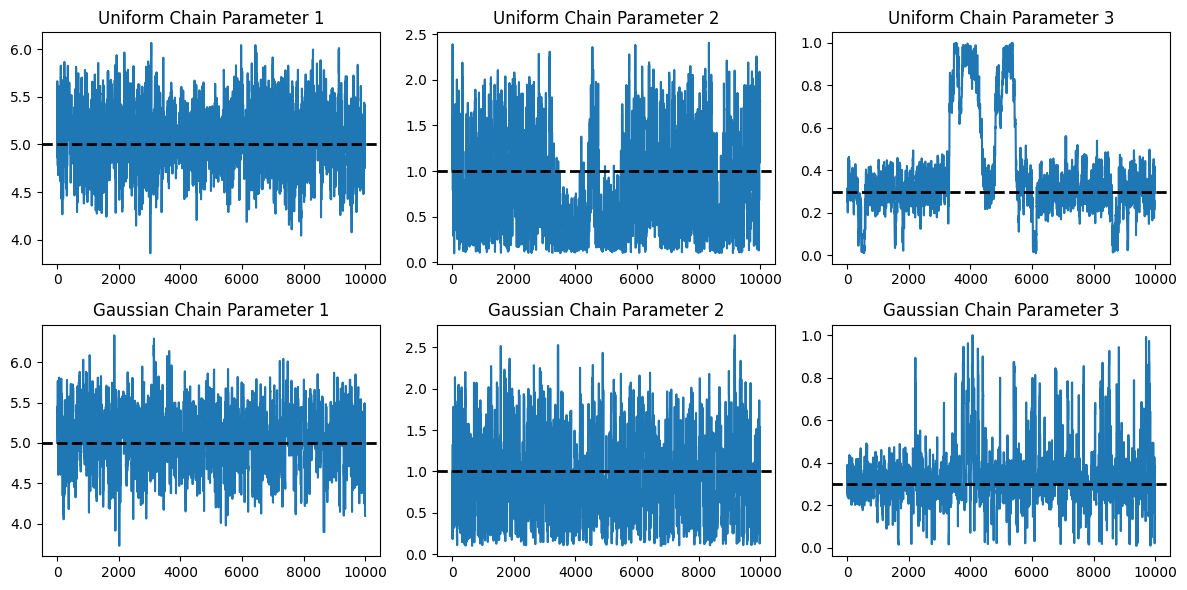

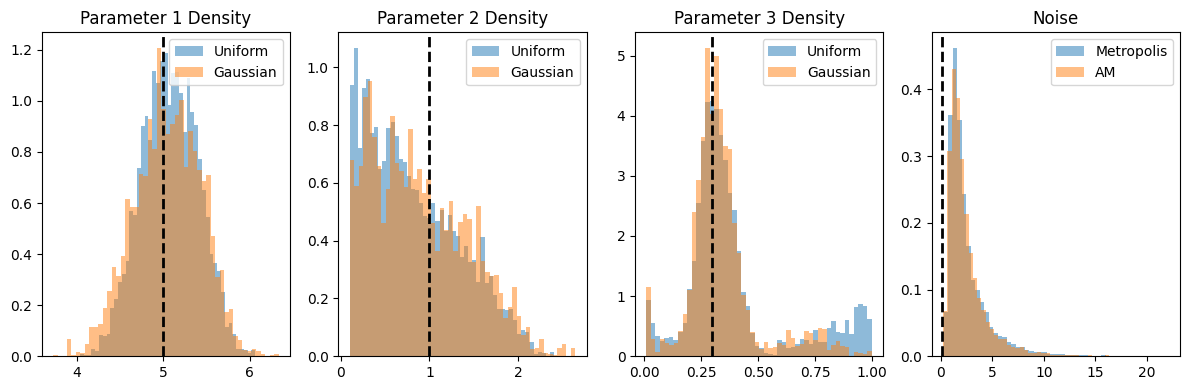

In [25]:

# Plot results
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.plot(chain_Met[i, :])
    plt.axhline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Uniform Chain Parameter {i+1}')
    
    plt.subplot(2, 3, i + 4)
    plt.plot(chain_AM[i, :])
    plt.axhline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Gaussian Chain Parameter {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 4, i + 1)
    plt.hist(chain_Met[i, :], bins=50, density=True, alpha=0.5, label="Uniform")
    plt.hist(chain_AM[i, :], bins=50, density=True, alpha=0.5, label="Gaussian")
    plt.axvline(param_star[i], color='k', linestyle='--', linewidth=2)
    plt.title(f'Parameter {i+1} Density')
    plt.legend()

plt.subplot(1, 4, 4)
plt.hist(s2_Met, bins=50, density=True, alpha=0.5, label="Metropolis")
plt.hist(s2_AM, bins=50, density=True, alpha=0.5, label="AM")
plt.axvline(noise_var, color='k', linestyle='--', linewidth=2)
plt.title('Noise')
plt.legend()
plt.tight_layout()
plt.show()